In [4]:
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from download_wb_data import download_wb_data
from lib_gather_data import get_country_name_dicts, df_to_iso3
from wb_api_wrapper import *

import warnings
warnings.filterwarnings("ignore")

In [5]:
root_dir = "./"
any_to_wb, iso3_to_wb, iso2_iso3 = get_country_name_dicts(root_dir)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs


In [6]:
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 50)

# Data Gathering

In [7]:
gdp_pc = get_wb_series('NY.GDP.PCAP.PP.KD', 'gdp_pc').dropna().astype(float).to_frame().reset_index()
gdp_pc = gdp_pc.loc[gdp_pc.groupby('country').year.idxmax()].drop('year', axis=1)
gdp_pc = df_to_iso3(gdp_pc, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gdp_pc)

            gdp_pc
iso3              
AFG    1516.273265
ALB   15492.067404
DZA   11198.233483
AGO    5906.115677
ATG   22321.870019
...            ...
VUT    2785.903860
VNM   11396.531305
PSE    5722.409175
ZMB    3365.873780
ZWE    2207.957033

[194 rows x 1 columns]


array([[<Axes: title={'center': 'gdp_pc'}>]], dtype=object)

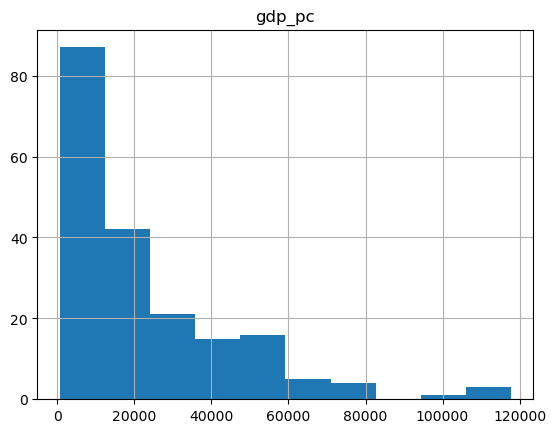

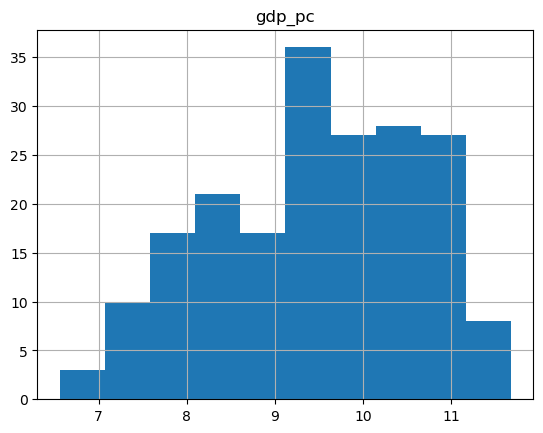

In [8]:
gdp_pc.hist()
(np.log(gdp_pc)).hist()

In [9]:
gvt_effectiveness = get_wb_series('GE.EST', 'GE_EST').dropna().astype(float).to_frame().reset_index()
gvt_effectiveness = gvt_effectiveness.loc[gvt_effectiveness.groupby('country').year.idxmax()].drop('year', axis=1)
gvt_effectiveness = df_to_iso3(gvt_effectiveness, 'country', any_to_wb).set_index('iso3', drop=True).drop('country', axis=1)
print(gvt_effectiveness)

        GE_EST
iso3          
AFG  -1.879552
ALB   0.065063
DZA  -0.513090
ASM   0.667918
AND   1.495305
...        ...
VIR   0.667918
PSE  -0.900953
YEM  -2.232542
ZMB  -0.658233
ZWE  -1.254613

[205 rows x 1 columns]


array([[<Axes: title={'center': 'GE_EST'}>]], dtype=object)

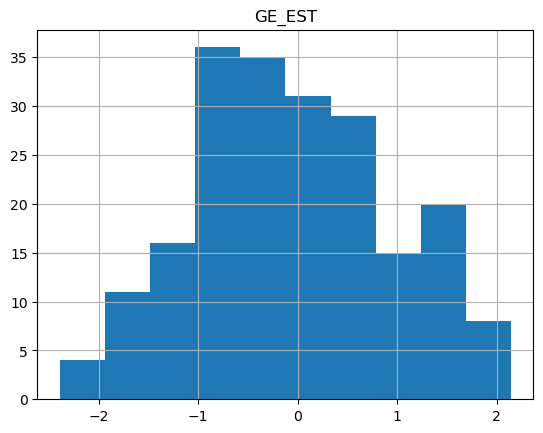

In [10]:
gvt_effectiveness.hist()

In [11]:
remittances = get_wb_series('BX.TRF.PWKR.DT.GD.ZS', 'remittances_gdp').dropna().astype(float).to_frame().reset_index()
remittances = remittances.loc[remittances.groupby('country').year.idxmax()].drop('year', axis=1)
remittances = df_to_iso3(remittances, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(remittances)

      remittances_gdp
iso3                 
AFG          2.102828
ALB          9.226106
DZA          0.902738
AND          1.593959
AGO          0.013116
...               ...
VNM          3.216862
PSE         21.186165
YEM         17.209770
ZMB          0.834892
ZWE         11.273013

[196 rows x 1 columns]


array([[<Axes: title={'center': 'remittances_gdp'}>]], dtype=object)

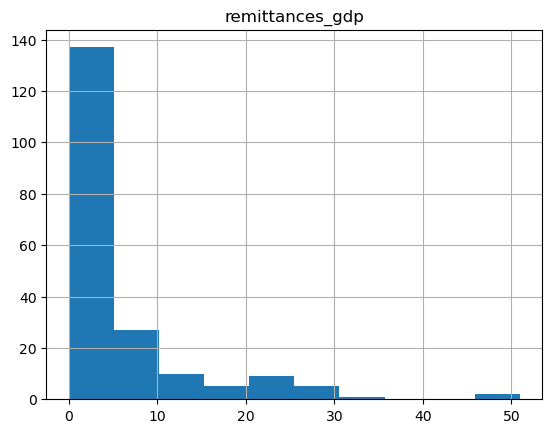

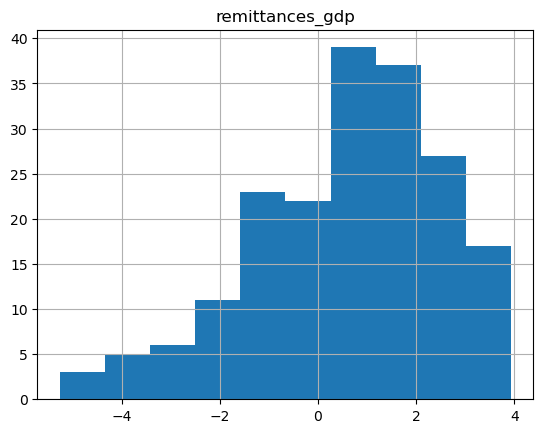

In [12]:
remittances.hist()
np.log(remittances[remittances > 0]).hist()

In [13]:
social_prot_expenditure = pd.read_excel("./inputs/social_share_regression/ILO/tableA4.3_data.xlsx", index_col=0)
social_prot_expenditure = social_prot_expenditure["Total expenditure on social protection (excluding health)"]
social_prot_expenditure.rename('ILO_social', inplace=True)
social_prot_expenditure = social_prot_expenditure.replace('...', np.nan).dropna()
social_prot_expenditure = social_prot_expenditure.astype(float)
social_prot_expenditure /= 100
social_prot_expenditure = df_to_iso3(social_prot_expenditure.reset_index(), 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
print(social_prot_expenditure)

      ILO_social
iso3            
DZA        0.089
EGY        0.095
LBY        0.044
MAR        0.045
SDN        0.007
...          ...
SVN        0.167
ESP        0.168
SWE        0.195
CHE        0.128
GBR        0.151

[185 rows x 1 columns]


array([[<Axes: title={'center': 'ILO_social'}>]], dtype=object)

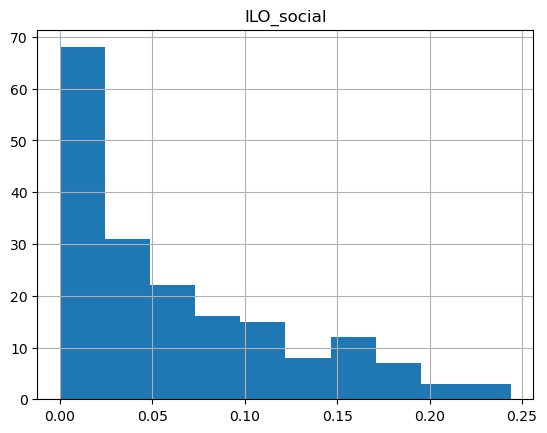

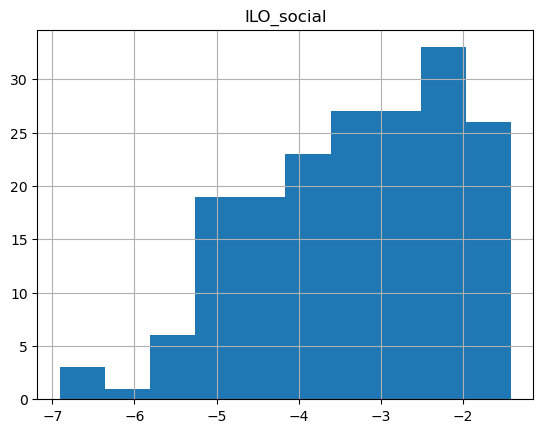

In [14]:
social_prot_expenditure.hist()
np.log(social_prot_expenditure[social_prot_expenditure > 0]).hist()

In [15]:
wb_country_classification = pd.read_excel("./inputs/WB_country_classification/country_classification.xlsx")[['Economy', 'Region', 'Income group']]
wb_country_classification.dropna(inplace=True)
wb_country_classification.rename(columns={'Economy': 'country', 'Region': 'region', 'Income group': 'income_group'}, inplace=True)
wb_country_classification.set_index('country', inplace=True)
wb_country_classification = df_to_iso3(wb_country_classification.reset_index(), 'country', any_to_wb).dropna().set_index('iso3').drop('country', axis=1)
for r in wb_country_classification['region'].unique():
    wb_country_classification[r.replace('&', '').replace('  ', ' ').replace(' ', '_').replace('-', '_')] = wb_country_classification['region'] == r
for ig in wb_country_classification['income_group'].unique():
    wb_country_classification[ig.replace(' ', '_')] = wb_country_classification['income_group'] == ig
print(wb_country_classification)

                          region         income_group  Latin_America_Caribbean  South_Asia  Sub_Saharan_Africa  Europe_Central_Asia  \
iso3                                                                                                                                  
ABW    Latin America & Caribbean          High income                     True       False               False                False   
AFG                   South Asia           Low income                    False        True               False                False   
AGO           Sub-Saharan Africa  Lower middle income                    False       False                True                False   
ALB        Europe & Central Asia  Upper middle income                    False       False               False                 True   
AND        Europe & Central Asia          High income                    False       False               False                 True   
...                          ...                  ...  

In [16]:
gini_index = get_wb_series('SI.POV.GINI', 'gini_index').dropna().astype(float).to_frame().reset_index()
gini_index = gini_index.loc[gini_index.groupby('country').year.idxmax()].drop('year', axis=1)
gini_index = df_to_iso3(gini_index, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gini_index)

      gini_index
iso3            
ALB         29.4
DZA         27.6
AGO         51.3
ARG         42.0
ARM         27.9
...          ...
VNM         36.8
PSE         33.7
YEM         36.7
ZMB         55.9
ZWE         50.3

[162 rows x 1 columns]


array([[<Axes: title={'center': 'gini_index'}>]], dtype=object)

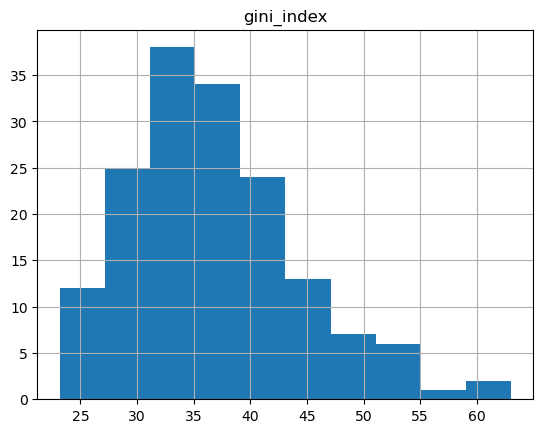

In [17]:
gini_index.hist()

In [18]:
fsc = [
    'Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 
    'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine','Uzbekistan'
]
former_yugoslavia = [
    'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Montenegro', 'North Macedonia', 'Serbia', 
    'Slovenia'
]
former_socialist_countries = fsc + former_yugoslavia + [
    'Albania', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Slovakia'
]

fsr_old = [
    'Albania', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Estonia',
    'Georgia', 'Hungary', 'Kazakhstan', 'Kosovo', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'North Macedonia', 'Moldova',
    'Montenegro', 'Poland', 'Romania', 'Russian Federation', 'Serbia', 'Slovak Republic', 'Slovenia', 'Tajikistan',
    'Turkmenistan', 'Uzbekistan'
]

fsc = pd.DataFrame(
    index=pd.Index(former_socialist_countries, name='country'),
    data=True,
    columns=['FSR']
)
fsc = df_to_iso3(fsc.reset_index(), 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
print(fsc)

       FSR
iso3      
ARM   True
AZE   True
BLR   True
EST   True
GEO   True
KAZ   True
KGZ   True
LVA   True
LTU   True
MDA   True
RUS   True
TJK   True
TKM   True
UKR   True
UZB   True
BIH   True
HRV   True
XKX   True
MNE   True
MKD   True
SRB   True
SVN   True
ALB   True
BGR   True
CZE   True
HUN   True
POL   True
ROU   True
SVK   True


        GE_EST  remittances_gdp  ILO_social                      region         income_group Latin_America_Caribbean South_Asia Sub_Saharan_Africa  \
iso3                                                                                                                                                 
ALB   0.065063         9.226106       0.092       Europe & Central Asia  Upper middle income                   False      False              False   
DZA  -0.513090         0.902738       0.089  Middle East & North Africa  Lower middle income                   False      False              False   
AGO  -1.040429         0.013116       0.021          Sub-Saharan Africa  Lower middle income                   False      False               True   
ARG  -0.282877         0.200821       0.109   Latin America & Caribbean  Upper middle income                    True      False              False   
ARM  -0.314230        10.427740       0.068       Europe & Central Asia  Upper middle income        

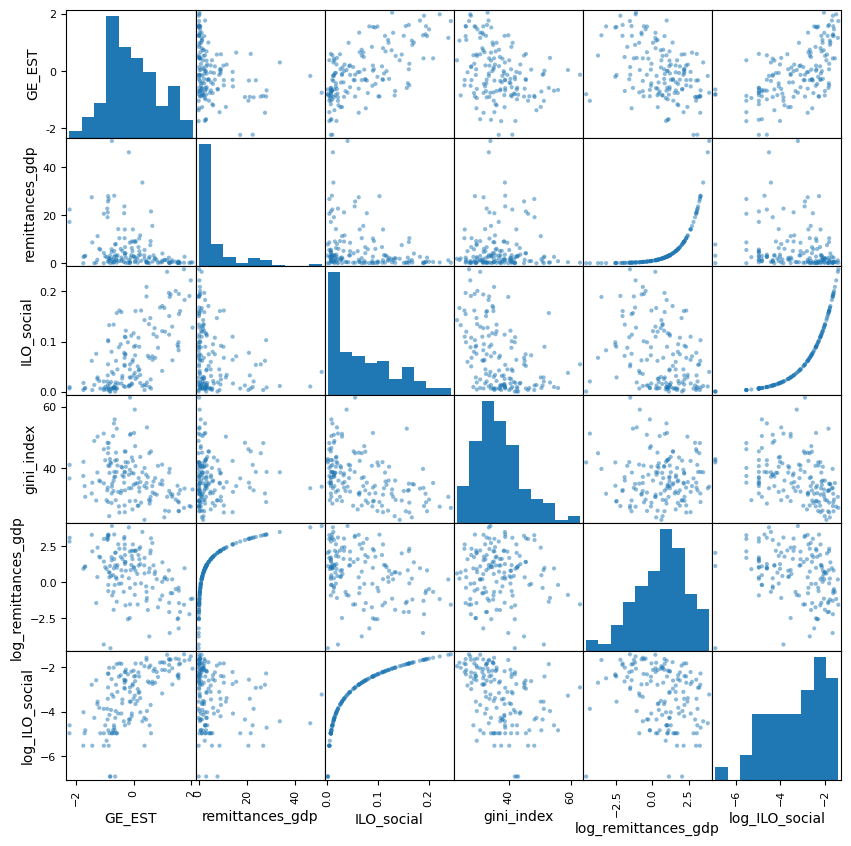

In [19]:
# X = pd.concat([gdp_pc, gvt_effectiveness, remittances, social_prot_expenditure, wb_country_classification, gini_index], axis=1).dropna()
X = pd.concat([gvt_effectiveness, remittances, social_prot_expenditure, wb_country_classification, gini_index], axis=1)
X = pd.concat([X, fsc], axis=1)
X['FSR'] = X['FSR'].fillna(False).astype(int)
X.dropna(inplace=True)
categorial_columns = list(wb_country_classification.columns) + ['FSR']
print(X)
X['log_remittances_gdp'] = np.log(X['remittances_gdp'])
X['log_ILO_social'] = np.log(X['ILO_social'])
X = X.replace({np.inf: np.nan, -np.inf: np.nan})
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pd.plotting.scatter_matrix(X.drop(categorial_columns, axis=1), ax=ax)
print("\n\n###################\nCorrelation\n###################\n", X.drop(categorial_columns, axis=1).corr())

In [20]:
_, Y_ = download_wb_data(root_dir=root_dir, include_remitances=True, use_additional_data=False, drop_incomplete=False)
Y_ = Y_.drop('axfin', axis=1)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs
loading file FINDEX/findex_axfin.csv from inputs
Full data for 89 countries.


In [21]:
bottom_40 = Y_.drop(['q3', 'q4', 'q5'], level='income_cat').dropna()
bottom_40 = bottom_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / bottom_40.income_share.groupby('iso3').sum()
bottom_40.rename('social_bottom40', inplace=True)
top_60 = Y_.drop(['q1', 'q2'], level='income_cat').dropna()
top_60 = top_60[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_60.income_share.groupby('iso3').sum()
top_60.rename('social_top60', inplace=True)
top_40 = Y_.drop(['q1', 'q2'], level='income_cat').dropna()
top_40 = top_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_40.income_share.groupby('iso3').sum()
top_40.rename('social_top40', inplace=True)
print(bottom_40)
print(top_60)
print(top_40)

iso3
AGO    0.151075
ALB    0.212207
ARG    0.239702
ARM    0.608379
AZE    0.020374
         ...   
XKX    0.263828
YEM    0.143651
ZAF    0.783326
ZMB    0.008404
ZWE    0.091104
Name: social_bottom40, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top60, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top40, Length: 101, dtype: float64


In [22]:
Y = Y_.social.unstack('income_cat').dropna(how='all')
Y.columns = [f'social_{q}' for q in Y.columns]
Y = pd.concat([Y, bottom_40, top_60, top_40], axis=1).dropna()
print(Y)

      social_q1  social_q2  social_q3  social_q4  social_q5  social_bottom40  social_top60  social_top40
iso3                                                                                                    
ALB    0.243888   0.192046   0.178422   0.182160   0.147807         0.212207      0.164662      0.164662
AGO    0.126905   0.163002   0.134731   0.155588   0.139974         0.151075      0.142823      0.142823
ARG    0.302076   0.207570   0.189000   0.188540   0.180409         0.239702      0.184092      0.184092
ARM    0.750543   0.511542   0.444049   0.363883   0.173967         0.608379      0.288714      0.288714
AZE    0.028609   0.013976   0.018383   0.014529   0.014453         0.020374      0.015340      0.015340
...         ...        ...        ...        ...        ...              ...           ...           ...
PSE    0.041010   0.031931   0.030221   0.036712   0.051376         0.035383      0.042830      0.042830
ZMB    0.007057   0.009066   0.007351   0.006029   0.00

In [23]:
regression_data = pd.concat([X, Y], axis=1).loc[Y.index]
print(regression_data)

        GE_EST  remittances_gdp  ILO_social                      region         income_group Latin_America_Caribbean South_Asia Sub_Saharan_Africa  \
iso3                                                                                                                                                 
ALB   0.065063         9.226106       0.092       Europe & Central Asia  Upper middle income                   False      False              False   
AGO  -1.040429         0.013116       0.021          Sub-Saharan Africa  Lower middle income                   False      False               True   
ARG  -0.282877         0.200821       0.109   Latin America & Caribbean  Upper middle income                    True      False              False   
ARM  -0.314230        10.427740       0.068       Europe & Central Asia  Upper middle income                   False      False              False   
AZE  -0.040658         5.017754       0.060       Europe & Central Asia  Upper middle income        

# Regression

In [24]:
income_quintiles = Y.columns
selected_formulas = {}

In [25]:
def run_regressions(formulas_, target_variable_, verbose=True):
    regression_results = pd.DataFrame(
        columns=['R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
        index=[i + 1 for i in range(len(formulas_))]
    )
    for formula_nr, formula in enumerate(formulas_):
        if verbose:
            print(f"\n\n\n###############################\nRegression for {target_variable_}\n###############################\n")
            print(f"++++++ formula {formula_nr + 1}: {formula} ++++++")
        features = [f for f in formula.split(' ~ ')[1].split(' + ') if f not in categorial_columns]
        if len(features) > 1 and verbose:
            vif_data = pd.DataFrame(
                columns=['VIF'],
                index=features,
                data=[variance_inflation_factor(X[features].dropna().values, i) for i in range(len(features))]
            )
            print(vif_data)
        model = smf.ols(formula=formula.format(target_variable_), data=regression_data, missing='drop')
        regression = model.fit()
        if verbose:
            print(regression.summary())
        regression_results.loc[formula_nr + 1] = [regression.rsquared, regression.rsquared_adj, regression.aic, regression.bic, regression.fvalue, regression.f_pvalue]
    return regression_results

## Q1

In [26]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR',
    # '{} ~ ILO_social + GE_EST + FSR',
]
income_quintile = income_quintiles[0]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:              social_q1   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     8.766
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.88e-10
Time:                        10:47:17   Log-Likelihood:                 51.233
No. Observations:                  94   AIC:                            -76.47
Df Residuals:                      81   BIC:                            -43.40
Df Model:                          12            

## Q2

In [27]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + FSR + Low_income + Lower_middle_income',
    # '{} ~ ILO_social + FSR + Low_income + Lower_middle_income',
]
income_quintile = income_quintiles[1]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:              social_q2   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     7.116
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.13e-08
Time:                        10:47:18   Log-Likelihood:                 65.295
No. Observations:                  94   AIC:                            -104.6
Df Residuals:                      81   BIC:                            -71.53
Df Model:                          12            

## Q3

In [28]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
income_quintile = income_quintiles[2]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:              social_q3   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     6.627
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           4.09e-08
Time:                        10:47:18   Log-Likelihood:                 72.464
No. Observations:                  94   AIC:                            -118.9
Df Residuals:                      81   BIC:                            -85.87
Df Model:                          12            

## Q4

In [29]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
income_quintile = income_quintiles[3]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:              social_q4   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.548
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           7.91e-07
Time:                        10:47:18   Log-Likelihood:                 79.572
No. Observations:                  94   AIC:                            -133.1
Df Residuals:                      81   BIC:                            -100.1
Df Model:                          12            

## Q5

In [30]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social + log_remittances_gdp + region',
    '{} ~ log_ILO_social + log_remittances_gdp + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
]
income_quintile = income_quintiles[4]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:              social_q5   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     3.840
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000122
Time:                        10:47:18   Log-Likelihood:                 98.711
No. Observations:                  94   AIC:                            -171.4
Df Residuals:                      81   BIC:                            -138.4
Df Model:                          12            

## Bottom 40%

In [31]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + FSR + Low_income + Lower_middle_income',
]
income_quintile = income_quintiles[5]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_bottom40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:        social_bottom40   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     8.251
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           6.49e-10
Time:                        10:47:18   Log-Likelihood:                 62.963
No. Observations:                  94   AIC:                            -99.93
Df Residuals:                      81   BIC:                            -66.86
Df Model:                          12      

## Top 60%

In [32]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa + Sub_Saharan_Africa + Latin_America_Caribbean',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa + Latin_America_Caribbean',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa',
]
income_quintile = income_quintiles[6]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_top60
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:           social_top60   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           9.97e-07
Time:                        10:47:18   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

## Top 40%

In [33]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + income_group + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + GE_EST + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
]
income_quintile = income_quintiles[7]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           9.97e-07
Time:                        10:47:18   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

In [34]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa',
]
income_quintile = income_quintiles[7]
print("\n\n", run_regressions(formulas, income_quintile))
selected_formulas[income_quintile] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.207326
GE_EST               1.214359
log_remittances_gdp  1.362559
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           9.97e-07
Time:                        10:47:18   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

In [35]:
result = pd.DataFrame(
    columns=['formula', 'R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
    index=income_quintiles,
    data=[[selected_formulas[i], *run_regressions([selected_formulas[i]], i, verbose=False).iloc[0]] for i in income_quintiles]
)
result

,formula,R2,Adj. R2,AIC,BIC,F-statistic,Prob(F-statistic)
social_q1,{} ~ ILO_social + GE_EST + remittances_gdp + FSR,0.544685,0.524449,-89.313992,-76.544608,26.916340,1.073401e-14
social_q2,{} ~ ILO_social + remittances_gdp + FSR + Low_...,0.518834,0.491802,-121.527410,-106.204148,19.193445,6.528602e-13
social_q3,{} ~ ILO_social + remittances_gdp + Latin_Amer...,0.490106,0.455340,-132.189272,-114.312133,14.097469,3.505169e-11
social_q4,{} ~ ILO_social + remittances_gdp + Latin_Amer...,0.437778,0.399445,-145.315213,-127.438075,11.420320,2.080369e-09
social_q5,{} ~ log_ILO_social + Middle_East_North_Africa...,0.283995,0.260390,-181.435020,-171.219513,12.031351,1.051208e-06
social_bottom40,{} ~ ILO_social + remittances_gdp + FSR + Low_...,0.558493,0.533689,-117.344194,-102.020933,22.516441,1.579282e-14
social_top60,{} ~ ILO_social + log_remittances_gdp + Lower_...,0.398648,0.364480,-164.762523,-149.502755,11.667365,1.158721e-08
social_top40,{} ~ ILO_social + log_remittances_gdp + Lower_...,0.398648,0.364480,-164.762523,-149.502755,11.667365,1.158721e-08


In [36]:
selected_formulas = {
    'q1': 'social_q1',
    'q2': 'social_q2',
    'q3': 'social_q3',
    # 'q4': 'social_q4',
    # 'q5': 'social_q5',
    'q4': 'social_top40',
    'q5': 'social_top40',
}
selected_formulas

{'q1': 'social_q1',
 'q2': 'social_q2',
 'q3': 'social_q3',
 'q4': 'social_top40',
 'q5': 'social_top40'}

the previously selected formulas were:

- 'social_p ~ np.log(ILO_social) + GE_EST + FSR'
- 'social_r ~ ILO_social + GE_EST + FSR'

# Prediction

In [37]:
def predict_social(formula, data, target_variable_):
    model = smf.ols(formula=formula.format(target_variable_), data=regression_data, missing='drop')
    regression = model.fit()
    return regression.predict(data)

In [38]:
new_countries = np.setdiff1d(X.index, Y.index)
social_predicted = pd.concat([predict_social(result.loc[selected_formulas[q], 'formula'], X.loc[new_countries], target_var).rename(q) for q, target_var in selected_formulas.items()], axis=1)
social_predicted.columns.name = 'income_cat'
social_predicted = social_predicted.stack('income_cat').rename('social')
social_predicted

iso3  income_cat
AUS   q1            0.412696
      q2            0.273202
      q3            0.310088
      q4            0.202857
      q5            0.202857
                      ...   
VUT   q1            0.171669
      q2            0.130994
      q3            0.139060
      q4            0.124321
      q5            0.124321
Name: social, Length: 273, dtype: float64

In [39]:
social_predicted.to_csv("./inputs/social_share_regression/social_predicted.csv", header=True)